<a href="https://colab.research.google.com/github/rush3508/Rocketlab_Stock_Price/blob/main/Rocket_Lab_Stock_Prediction_LTSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install yfinance pandas_datareader openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.4/251.4 kB 2.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as pdr
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from datetime import datetime, timedelta

# Ensure yfinance overrides
yf.pdr_override()

# Get the stock quote
df = pdr.get_data_yahoo('RKLB', start='2022-04-01', end=datetime.now())
print(df.head())

# Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


[*********************100%%**********************]  1 of 1 completed

            Open   High   Low  Close  Adj Close   Volume
Date                                                    
2022-04-01  8.05  8.110  7.76   7.92       7.92  2601300
2022-04-04  8.02  8.395  7.95   8.30       8.30  3841100
2022-04-05  8.33  8.350  8.08   8.20       8.20  3379300
2022-04-06  8.14  8.266  7.98   8.06       8.06  4171600
2022-04-07  8.02  8.090  7.74   7.93       7.93  4508000


Epoch 1/10
470/470 [==============================] - 17s 13ms/step - loss: 0.0137
Epoch 2/10
470/470 [==============================] - 6s 12ms/step - loss: 0.0080
Epoch 3/10
470/470 [==============================] - 5s 11ms/step - loss: 0.0057
Epoch 4/10
470/470 [==============================] - 5s 11ms/step - loss: 0.0057
Epoch 5/10
470/470 [==============================] - 5s 12ms/step - loss: 0.0052
Epoch 6/10
470/470 [==============================] - 5s 10ms/step - loss: 0.0048
Epoch 7/10
470/470 [==============================] - 6s 12ms/step - loss: 0.0041
Epoch 8/10
470/470 [==============================] - 5s 10ms/step - loss: 0.0042
Epoch 9/10
470/470 [==============================] - 6s 14ms/step - loss: 0.0037
Epoch 10/10
1/1 [==============================] - 1s 946ms/step
RMSE:  0.17807189097156398
1/1 [==============================] - 0s 18ms/step


<ipython-input-3-2682dd68fe75>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


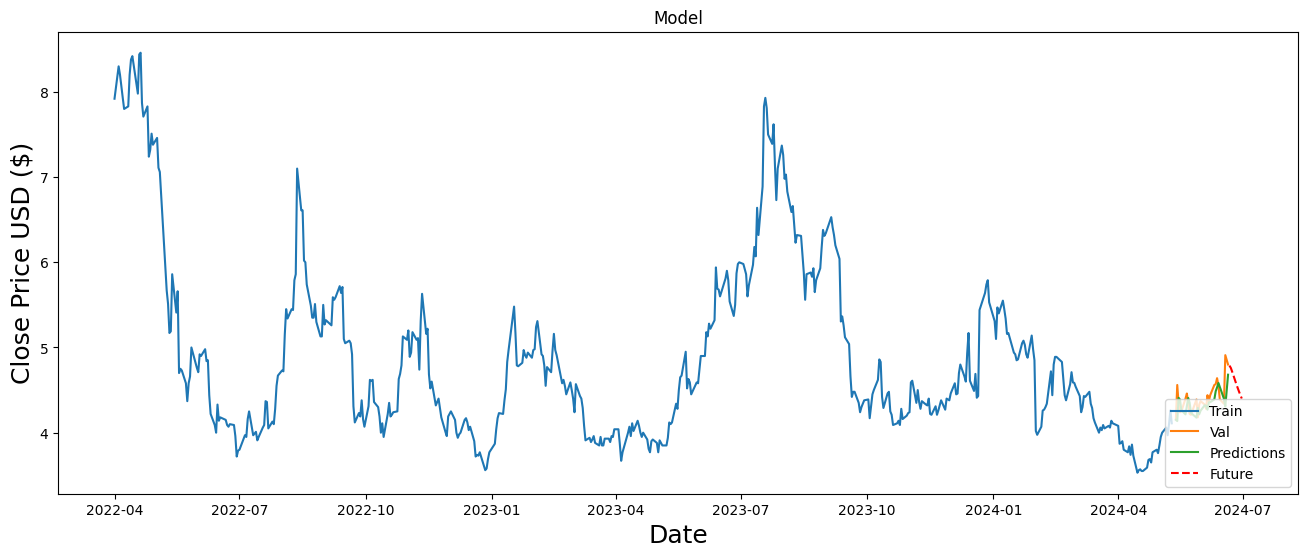

In [3]:
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil(len(dataset) * .95))

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Create the training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the LSTM model with additional layers and dropout
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))  # Add dropout to prevent overfitting
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with more epochs
model.fit(x_train, y_train, batch_size=1, epochs=10)

# Create the testing data set
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('RMSE: ', rmse)

# Predict the next 10 days
last_60_days = scaled_data[-60:]
next_10_days = []

for i in range(10):
    X_test = np.array([last_60_days])
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    pred_price = model.predict(X_test)
    pred_price_unscaled = scaler.inverse_transform(pred_price)
    next_10_days.append(pred_price_unscaled[0, 0])
    last_60_days = np.append(last_60_days, pred_price, axis=0)[-60:]

# Create a dataframe for the next 10 days
last_date = df.index[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, 11)]
future_predictions = pd.DataFrame(data={'Date': future_dates, 'Close': next_10_days})
future_predictions.set_index('Date', inplace=True)

# Create dataframes for plotting and saving
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Save to Excel
with pd.ExcelWriter('stock_predictions.xlsx') as writer:
    train.to_excel(writer, sheet_name='Train')
    valid.to_excel(writer, sheet_name='Validation')
    future_predictions.to_excel(writer, sheet_name='Future')

# Plot the data
plt.figure(figsize=(16, 6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.plot(future_predictions['Close'], linestyle='dashed', color='red')
plt.legend(['Train', 'Val', 'Predictions', 'Future'], loc='lower right')
plt.show()

[*********************100%%**********************]  1 of 1 completed


            Open   High   Low  Close  Adj Close   Volume
Date                                                    
2022-04-01  8.05  8.110  7.76   7.92       7.92  2601300
2022-04-04  8.02  8.395  7.95   8.30       8.30  3841100
2022-04-05  8.33  8.350  8.08   8.20       8.20  3379300
2022-04-06  8.14  8.266  7.98   8.06       8.06  4171600
2022-04-07  8.02  8.090  7.74   7.93       7.93  4508000
Epoch 1/20
470/470 [==============================] - 11s 13ms/step - loss: 0.0121
Epoch 2/20
470/470 [==============================] - 5s 10ms/step - loss: 0.0072
Epoch 3/20
470/470 [==============================] - 6s 12ms/step - loss: 0.0059
Epoch 4/20
470/470 [==============================] - 5s 10ms/step - loss: 0.0050
Epoch 5/20
470/470 [==============================] - 5s 10ms/step - loss: 0.0048
Epoch 6/20
470/470 [==============================] - 6s 12ms/step - loss: 0.0048
Epoch 7/20
470/470 [==============================] - 5s 10ms/step - loss: 0.0044
Epoch 8/20
470/470 [======

<ipython-input-6-3fd437c6d155>:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


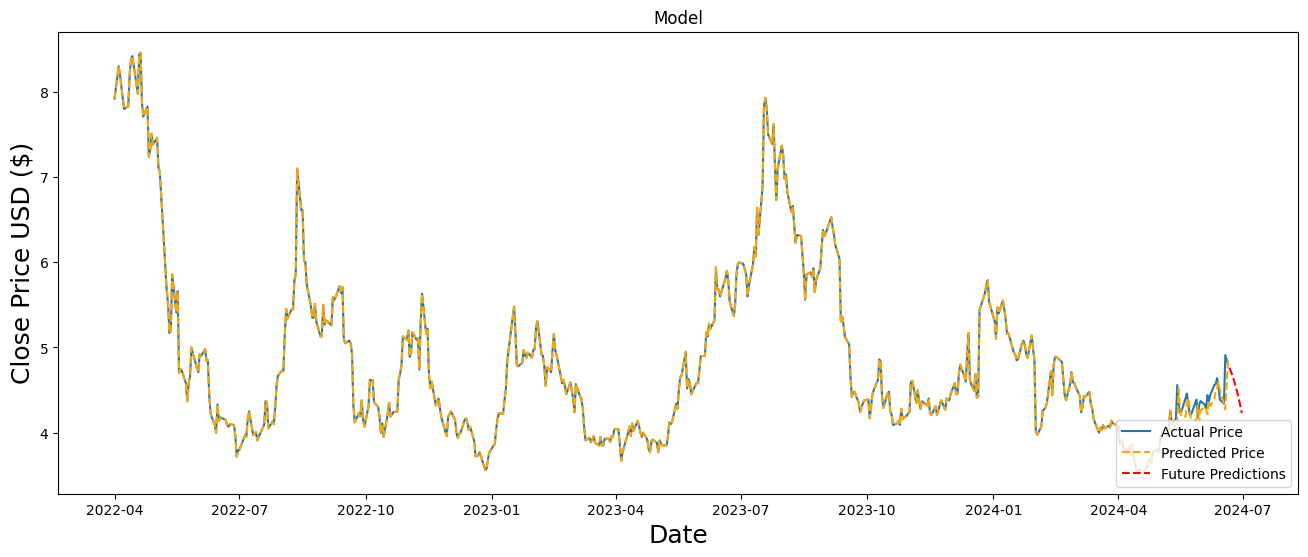

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as pdr
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from datetime import datetime, timedelta

# Ensure yfinance overrides
yf.pdr_override()

# Get the stock quote
df = pdr.get_data_yahoo('RKLB', start='2022-04-01', end=datetime.now())
print(df.head())

# Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])

# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil(len(dataset) * .95))

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Create the training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the LSTM model with additional layers and dropout
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))  # Add dropout to prevent overfitting
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with more epochs
model.fit(x_train, y_train, batch_size=1, epochs=20)

# Create the testing data set
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('RMSE: ', rmse)

# Predict the next 10 days
last_60_days = scaled_data[-60:]
next_10_days = []

for i in range(10):
    X_test = np.array([last_60_days])
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    pred_price = model.predict(X_test)
    pred_price_unscaled = scaler.inverse_transform(pred_price)
    next_10_days.append(pred_price_unscaled[0, 0])
    last_60_days = np.append(last_60_days, pred_price, axis=0)[-60:]

# Create a dataframe for the next 10 days
last_date = df.index[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, 11)]
future_predictions = pd.DataFrame(data={'Date': future_dates, 'Close': next_10_days})
future_predictions.set_index('Date', inplace=True)

# Create dataframes for plotting and saving
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Combine all predictions for overlaying
all_predictions = np.concatenate((train['Close'].values, predictions.flatten()))

# Save to Excel
with pd.ExcelWriter('stock_predictions.xlsx') as writer:
    train.to_excel(writer, sheet_name='Train')
    valid.to_excel(writer, sheet_name='Validation')
    future_predictions.to_excel(writer, sheet_name='Future')

# Plot the data
plt.figure(figsize=(16, 6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(data.index, data['Close'], label='Actual Price')
plt.plot(data.index, all_predictions, linestyle='dashed', color='orange', label='Predicted Price')
plt.plot(future_predictions.index, future_predictions['Close'], linestyle='dashed', color='red', label='Future Predictions')
plt.legend(['Actual Price', 'Predicted Price', 'Future Predictions'], loc='lower right')
plt.show()


Use TPU instead of GPU.

[*********************100%%**********************]  1 of 1 completed


            Open   High   Low  Close  Adj Close   Volume
Date                                                    
2022-04-01  8.05  8.110  7.76   7.92       7.92  2601300
2022-04-04  8.02  8.395  7.95   8.30       8.30  3841100
2022-04-05  8.33  8.350  8.08   8.20       8.20  3379300
2022-04-06  8.14  8.266  7.98   8.06       8.06  4171600
2022-04-07  8.02  8.090  7.74   7.93       7.93  4508000
Epoch 1/12
470/470 [==============================] - 20s 34ms/step - loss: 0.0151
Epoch 2/12
470/470 [==============================] - 16s 33ms/step - loss: 0.0076
Epoch 3/12
470/470 [==============================] - 16s 35ms/step - loss: 0.0067
Epoch 4/12
470/470 [==============================] - 14s 31ms/step - loss: 0.0066
Epoch 5/12
470/470 [==============================] - 14s 30ms/step - loss: 0.0051
Epoch 6/12
470/470 [==============================] - 15s 32ms/step - loss: 0.0066
Epoch 7/12
470/470 [==============================] - 14s 30ms/step - loss: 0.0044
Epoch 8/12
470/470 [

<ipython-input-8-1f0d0036858f>:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


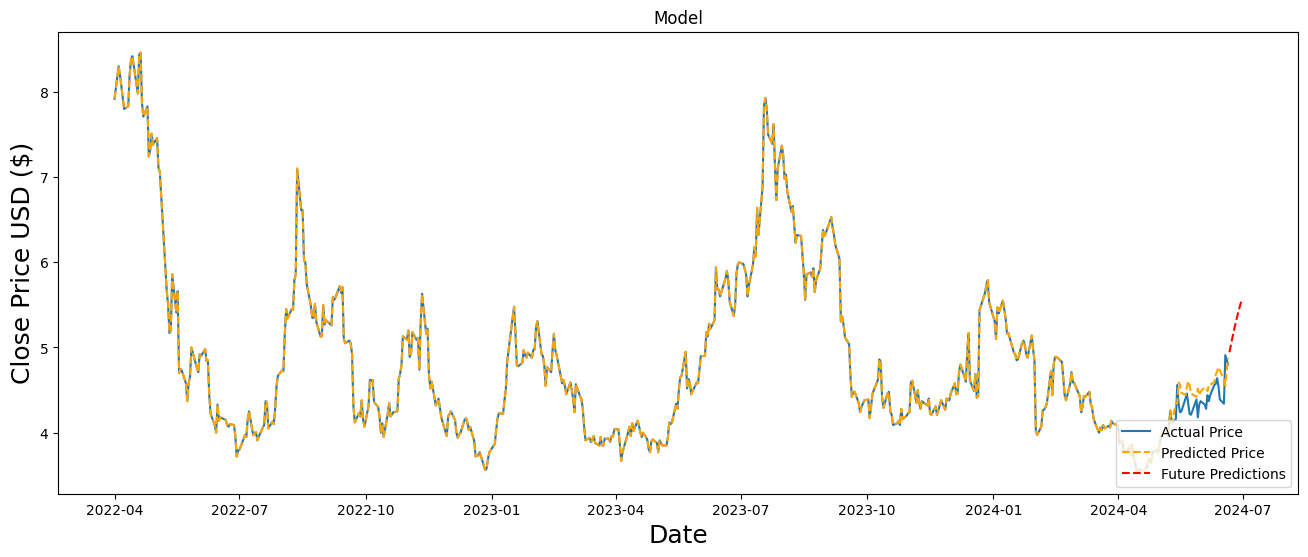

In [8]:
import numpy as np

import tensorflow as tf
import time
import os

import tensorflow.keras
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten,Input, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as pdr
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
#from keras.models import Sequential
#from keras.layers import Dense, LSTM, Dropout
from datetime import datetime, timedelta

# Ensure yfinance overrides
yf.pdr_override()

# Get the stock quote
df = pdr.get_data_yahoo('RKLB', start='2022-04-01', end=datetime.now())
print(df.head())

# Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])

# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil(len(dataset) * .95))

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Create the training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the LSTM model with additional layers and dropout
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))  # Add dropout to prevent overfitting
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with more epochs
model.fit(x_train, y_train, batch_size=1, epochs=12)

# Create the testing data set
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('RMSE: ', rmse)

# Predict the next 10 days
last_60_days = scaled_data[-60:]
next_10_days = []

for i in range(10):
    X_test = np.array([last_60_days])
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    pred_price = model.predict(X_test)
    pred_price_unscaled = scaler.inverse_transform(pred_price)
    next_10_days.append(pred_price_unscaled[0, 0])
    last_60_days = np.append(last_60_days, pred_price, axis=0)[-60:]

# Create a dataframe for the next 10 days
last_date = df.index[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, 11)]
future_predictions = pd.DataFrame(data={'Date': future_dates, 'Close': next_10_days})
future_predictions.set_index('Date', inplace=True)

# Create dataframes for plotting and saving
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Combine all predictions for overlaying
all_predictions = np.concatenate((train['Close'].values, predictions.flatten()))

# Save to Excel
with pd.ExcelWriter('stock_predictions.xlsx') as writer:
    train.to_excel(writer, sheet_name='Train')
    valid.to_excel(writer, sheet_name='Validation')
    future_predictions.to_excel(writer, sheet_name='Future')

# Plot the data
plt.figure(figsize=(16, 6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(data.index, data['Close'], label='Actual Price')
plt.plot(data.index, all_predictions, linestyle='dashed', color='orange', label='Predicted Price')
plt.plot(future_predictions.index, future_predictions['Close'], linestyle='dashed', color='red', label='Future Predictions')
plt.legend(['Actual Price', 'Predicted Price', 'Future Predictions'], loc='lower right')
plt.show()